In [97]:
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_rows = 20
import matplotlib.pyplot as plt
import numpy as np

bg = pd.read_excel('/content/gdrive/Shared drives/EEC193B Glucose Monitoring/Data/Burn_Glucose_022020.xlsx', skiprows = 0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [98]:
bg

,PER_CODE,Collection Date,Time Vitals,Systolic,Diastolic,MAP,HR,RR,Temp,CVP,GCS,Vent,Time_CBC,WBC,Hgb,Hct,Platelet,Time Labs,Na,K_pos,BUN,Creatnine,Glucose,Tbili,Chloride,V_CO2,PaO2,FIO2,PaCO2,HCO3,PH,Sepsis
0,21,2011-01-02,614.0,113.0,67.0,78.0,102.0,15.0,37.0,7.0,15.0,No,5.0,6.9,8.1,24.5,578.0,5.0,136.0,3.6,7.0,0.53,110.0,0.3,101.0,29.0,NaN,NaN,NaN,NaN,NaN,0
1,21,2011-01-03,600.0,137.0,67.0,85.0,105.0,16.0,37.3,7.0,15.0,No,59.0,7.8,7.9,25.1,615.0,59.0,137.0,3.7,8.0,0.55,130.0,0.3,104.0,27.0,NaN,NaN,NaN,NaN,NaN,0
2,21,2011-01-04,1000.0,124.0,56.0,73.0,104.0,18.0,37.5,7.0,15.0,No,208.0,8.9,8.7,26.6,607.0,208.0,135.0,3.4,8.0,0.53,172.0,0.3,103.0,24.0,NaN,NaN,NaN,NaN,NaN,0
3,21,2011-01-05,930.0,143.0,69.0,85.0,104.0,18.0,37.5,7.0,15.0,No,103.0,9.3,8.4,25.7,414.0,103.0,134.0,4.8,10.0,0.49,150.0,0.3,103.0,25.0,NaN,0.21,NaN,NaN,NaN,0
4,21,2011-01-06,1130.0,130.0,59.0,83.0,104.0,23.0,38.0,7.0,15.0,No,130.0,8.4,8.9,27.7,701.0,130.0,136.0,3.5,11.0,0.51,109.0,0.3,103.0,27.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,PCR-004-00018,2013-05-27,600.0,140.0,70.0,102.0,116.0,26.0,38.5,NaN,NaN,No,211.0,17.6,9.2,26.8,454.0,211.0,138.0,4.5,12.0,0.88,139.0,NaN,103.0,25.0,NaN,NaN,NaN,NaN,NaN,0
6537,PCR-004-00018,2013-05-28,600.0,158.0,53.0,82.0,110.0,22.0,37.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6538,PCR-004-00018,2013-05-29,600.0,133.0,51.0,72.0,120.0,22.0,38.5,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6539,PCR-004-00018,2013-05-30,600.0,118.0,49.0,73.0,118.0,22.0,38.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Data Preprocessing ##


In [0]:
def Drop_nan_row(df):
  
  drop_idx = []
  for i in range(len(df)):
    nan_count = 0
    for x in df.loc[i]:
      if str(x) == 'nan':
        nan_count += 1
    if nan_count >= 15:
      drop_idx.append(i)
    
  modified_df = df.drop(df.index[drop_idx], errors = 'ignore')
  modified_df = modified_df.reset_index(drop = True)

  return modified_df

In [0]:
def Drop_unrelated_cols(df):
  df = df.drop(columns = ['PER_CODE', 'Collection Date', 'Time Vitals', 'Time Labs'], errors = 'ignore')
  return df

In [0]:

def Drop_nan_col(df):
  
  num_rows = len(df)
  for x in df:
    num_nan = 0
    for i in df[x]:
      if str(i) == 'nan':
        num_nan += 1
    
    if (num_nan/num_rows) >= 0.2:
      df = df.drop(columns = x, errors = 'ignore')
  
  return df

In [0]:
def Complete_dataset(df):

  # Change "Yes" and "No" under "Vent" to 1 and 0
  df = df.replace('No', 0)
  df = df.replace('Yes', 1)

  # drop nan or replace them with other value
  df = df.dropna()
  df = df.reset_index(drop = True)

  return df

In [0]:
def data_preprocess(df):

  # drop rows that have too many nan
  df = Drop_nan_row(df)
  # drop times and patient ids
  df = Drop_unrelated_cols(df)
  # drop cols that have too many nan
  df = Drop_nan_col(df)
  # Replace all the other nans
  df = Complete_dataset(df)

  return df

In [0]:
bg = data_preprocess(bg)


## Model Training ##

In [105]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.6.2)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import imblearn

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras import optimizers
from keras.utils import plot_model


In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def prediction_score(prediction, groundtruth):
    precision = precision_score(groundtruth, prediction, average = None)
    f1 = f1_score(groundtruth, prediction, average = None)
    recall = recall_score(groundtruth, prediction, average = None)
    return precision, f1, recall


In [108]:
# model = Sequential()

# # Embedding layer
# model.add(
#     Embedding(
#         input_dim=len(bg) + 1,
#         output_dim=100,
#         weights=None,
#         trainable=True))

# # Recurrent layer
# model.add(
#     LSTM(
#         64, return_sequences=False, dropout=0.1,
#         recurrent_dropout=0.1))

# # Fully connected layer
# model.add(Dense(64, activation='relu'))

# # Dropout for regularization
# model.add(Dropout(0.5))

# # Output layer
# model.add(Dense(len(bg) + 1, activation='softmax'))

# # Compile the model
# model.compile(
#     optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)


test_y=np.reshape(test_y,(len(test_y),1))

test_y





array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [109]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 2.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)
f1_score_scores = [[],[]]
sensitivity = []
specificity = []
f1_pred= []

neurons = 8
batch_size=2
train_x_rus = train_x_rus.reshape(train_x_rus.shape[0], 1, train_x_rus.shape[1])
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])


model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, train_x_rus.shape[1], train_x_rus.shape[2]), stateful=True))
model.add(Dense(1))

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='Adam')
  
#model.fit(train_x_rus, train_y_rus, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
      

for i in range(0,10):

  model.fit(train_x_rus, train_y_rus, epochs=4, batch_size=batch_size, verbose=0, shuffle=False)
  predictions = model.predict(test_x,batch_size)
  
  predictions = np.floor(predictions)
  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

# #loss, accuracy, f1_score, precision, recall = model.evaluate(test, ytest, verbose=0)
# # pred_bool = np.argmax(predictions, axis=1)

# # print(classification_report(test_x, pred_bool))

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.5597863280097398
sensitivity =  0.5699903324560933
specificity =  0.5699903324560933


In [110]:
predictions

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

roc_auc_score =  0.6293839626188302


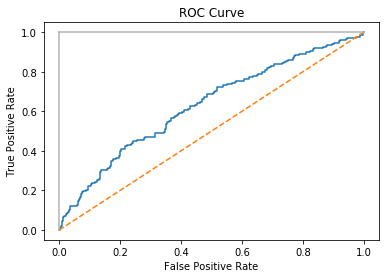

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x,batch_size)
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()